In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input/google-fpt-telecom-reviews-data','/kaggle/input/vietnamese-stopwords/stopwords.txt','/kaggle/input/train-classificate-data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/google-fpt-telecom-reviews-data/reviews.csv


# 🤖 Cài đặt các thư viện

In [3]:
import numpy as np
import networkx as nx
import pandas as pd
import tensorflow as tf
import torch

In [2]:
!pip install -q emoji
!pip install -q vncorenlp
!pip install -q py_vncorenlp
# !git clone https://github.com/vncorenlp/VnCoreNLP.git

In [5]:
# import re
# import nltk
# from nltk.corpus import stopwords
# from stop_words import get_stop_words
# stop_words_vi = get_stop_words('vi')
# from tqdm import tqdm
# import networkx as nx
# from collections import Counter

# import pandas as pd
# from nltk import ngrams
# from gensim.models import Word2Vec
# from wordcloud import WordCloud

# import sys
# import importlib
# import collections
# import itertools
# import matplotlib.pyplot as plt
# import logging

# 🌍 Khởi tạo môi trường cho VnCoreNLP

In [4]:
import requests

# URL của tệp VnCoreNLP-1.2.jar trên GitHub
url = 'https://github.com/vncorenlp/VnCoreNLP/releases/download/v1.1/VnCoreNLP-1.2.jar'

# Đường dẫn để lưu tệp sau khi tải về
output_path = 'VnCoreNLP/VnCoreNLP-1.2.jar'

# Tạo thư mục nếu chưa có
import os
if not os.path.exists('VnCoreNLP'):
    os.makedirs('VnCoreNLP')

# Tải tệp
response = requests.get(url, stream=True)
with open(output_path, 'wb') as file:
    for chunk in response.iter_content(chunk_size=1024):
        if chunk:
            file.write(chunk)

print("Đã tải tệp VnCoreNLP-1.2.jar thành công!")


Đã tải tệp VnCoreNLP-1.2.jar thành công!


In [12]:
# py_vncorenlp.download_model(save_dir='/kaggle/working/VnCoreNLP')

In [15]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## 🧮 Tiền xử lý dữ liệu

In [17]:
# https://github.com/nguyenvanhieuvn/text-classification-tutorial/blob/master/text_classification_tutorial.ipynb
# https://nguyenvanhieu.vn/phan-loai-van-ban-tieng-viet

import regex as re
import string
import emoji
import py_vncorenlp
from vncorenlp import VnCoreNLP
from nltk import flatten


# Remove HTML code
def remove_HTML(text):
    return re.sub(r'<[^>]*>', '', text)


# Standardize unicode
def convert_unicode(text):
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    charutf8 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    char1252 = char1252.split('|')
    charutf8 = charutf8.split('|')

    dic = {}
    for i in range(len(char1252)): dic[char1252[i]] = charutf8[i]
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dic[x.group()], text
    )


# Standardize accent typing
vowels_to_ids = {}
vowels_table = [
    ['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a' ],
    ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
    ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
    ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e' ],
    ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
    ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i' ],
    ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o' ],
    ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
    ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
    ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u' ],
    ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
    ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y' ]
]

for i in range(len(vowels_table)):
    for j in range(len(vowels_table[i]) - 1):
        vowels_to_ids[vowels_table[i][j]] = (i, j)


def is_valid_vietnamese_word(word):
    chars = list(word)
    vowel_indexes = -1
    for index, char in enumerate(chars):
        x, y = vowels_to_ids.get(char, (-1, -1))
        if x != -1:
            if vowel_indexes == -1: vowel_indexes = index
            else:
                if index - vowel_indexes != 1: return False
                vowel_indexes = index
    return True


def standardize_word_typing(word):
    if not is_valid_vietnamese_word(word): return word
    chars = list(word)
    dau_cau = 0
    vowel_indexes = []
    qu_or_gi = False

    for index, char in enumerate(chars):
        x, y = vowels_to_ids.get(char, (-1, -1))
        if x == -1: continue
        elif x == 9:  # check qu
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check gi
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True

        if y != 0:
            dau_cau = y
            chars[index] = vowels_table[x][0]

        if not qu_or_gi or index != 1:
            vowel_indexes.append(index)

    if len(vowel_indexes) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = vowels_to_ids.get(chars[1])
                chars[1] = vowels_table[x][dau_cau]
            else:
                x, y = vowels_to_ids.get(chars[2], (-1, -1))
                if x != -1: chars[2] = vowels_table[x][dau_cau]
                else: chars[1] = vowels_table[5][dau_cau] if chars[1] == 'i' else vowels_table[9][dau_cau]
            return ''.join(chars)
        return word

    for index in vowel_indexes:
        x, y = vowels_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = vowels_table[x][dau_cau]
            return ''.join(chars)

    if len(vowel_indexes) == 2:
        if vowel_indexes[-1] == len(chars) - 1:
            x, y = vowels_to_ids[chars[vowel_indexes[0]]]
            chars[vowel_indexes[0]] = vowels_table[x][dau_cau]
        else:
            x, y = vowels_to_ids[chars[vowel_indexes[1]]]
            chars[vowel_indexes[1]] = vowels_table[x][dau_cau]
    else:
        x, y = vowels_to_ids[chars[vowel_indexes[1]]]
        chars[vowel_indexes[1]] = vowels_table[x][dau_cau]
    return ''.join(chars)


def standardize_sentence_typing(text):
    words = text.lower().split()
    for index, word in enumerate(words):
        cw = re.sub(r'(^\p{P}*)([p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
        if len(cw) == 3: cw[1] = standardize_word_typing(cw[1])
        words[index] = ''.join(cw)
    return ' '.join(words)


# Normalize acronyms
# !wget https://gist.githubusercontent.com/behitek/7d9441c10b3c2739499fc5a4d9ea06fb/raw/df939245b3e841b62af115be4dcb3516dadc9fc5/teencode.txt
replace_list = {
    'ô kêi': 'ok', 'okie': 'ok', 'o kê': 'ok', 'okey': 'ok', 'ôkê': 'ok', 'oki': 'ok', 'oke': 'ok', 'okay': 'ok', 'okê': 'ok',
    'ok' : "tốt",
    'tks': 'cảm ơn', 'thks': 'cảm ơn', 'thanks': 'cảm ơn', 'ths': 'cảm ơn', 'thank': 'cảm ơn',
    'kg': 'không', 'not': 'không', 'k': 'không', 'kh': 'không', 'kô': 'không', 'hok': 'không', 'ko': 'không', 'khong': 'không', 'kp': 'không phải',
    'he he': 'tích cực', 'hehe': 'tích cực', 'hihi': 'tích cực', 'haha': 'tích cực', 'hjhj': 'tích cực', 'thick': 'tích cực',
    'lol': 'tiêu cực', 'cc': 'tiêu cực', 'huhu': 'tiêu cực', 'cute': 'dễ thương',

    'sz': 'cỡ', 'size': 'cỡ',
    'wa': 'quá', 'wá': 'quá', 'qá': 'quá',
    'đx': 'được', 'dk': 'được', 'dc': 'được', 'đk': 'được', 'đc': 'được',
    'vs': 'với', 'j': 'gì', '“': ' ', 'time': 'thời gian', 'm': 'mình', 'mik': 'mình', 'r': 'rồi', 'bjo': 'bao giờ', 'very': 'rất',

    'authentic': 'chuẩn chính hãng', 'aut': 'chuẩn chính hãng', 'auth': 'chuẩn chính hãng', 'date': 'hạn sử dụng', 'hsd': 'hạn sử dụng',
    'store': 'cửa hàng', 'sop': 'cửa hàng', 'shopE': 'cửa hàng', 'shop': 'cửa hàng',
    'sp': 'sản phẩm', 'product': 'sản phẩm', 'hàg': 'hàng',
    'ship': 'giao hàng', 'delivery': 'giao hàng', 'síp': 'giao hàng', 'order': 'đặt hàng',

    'gud': 'tốt', 'wel done': 'tốt', 'good': 'tốt', 'gút': 'tốt', 'tot': 'tốt', 'nice': 'tốt', 'perfect': 'rất tốt',
    'quality': 'chất lượng', 'chất lg': 'chất lượng', 'chat': 'chất', 'excelent': 'hoàn hảo', 'bt': 'bình thường',
    'sad': 'tệ', 'por': 'tệ', 'poor': 'tệ', 'bad': 'tệ',
    'beautiful': 'đẹp tuyệt vời', 'dep': 'đẹp',
    'xau': 'xấu', 'sấu': 'xấu',

    'thik': 'thích', 'iu': 'yêu', 'fake': 'giả mạo',
    'quickly': 'nhanh', 'quick': 'nhanh', 'fast': 'nhanh',
    'fresh': 'tươi', 'delicious': 'ngon',

    'hàng':'sản phẩm','tv':'truyền hình','dv':'dịch vụ','mạng':'internet','chổ':'chỗ', 'wifi':'internet',',wifi':'internet','cước':'giá tiền',

    'dt': 'điện thoại', 'fb': 'facebook', 'face': 'facebook', 'ks': 'khách sạn', 'nv': 'nhân viên',
    'nt': 'nhắn tin', 'ib': 'nhắn tin', 'tl': 'trả lời', 'trl': 'trả lời', 'rep': 'trả lời',
    'fback': 'feedback', 'fedback': 'feedback',
    'sd': 'sử dụng', 'sài': 'xài',

    '❤️': 'tích cực', '👍': 'tích cực', '🎉': 'tích cực', '😀': 'tích cực', '😍': 'tích cực', '😂': 'tích cực', '🤗': 'tích cực', '😙': 'tích cực', '🙂': 'tích cực',
    '😔': 'tiêu cực', '😓': 'tiêu cực', '😭😭😭' : 'tiêu cực', '😢': 'tiêu cực', '🙁': 'tiêu cực', '😞': 'tiêu cực',
    '⭐': 'star', '*': 'star', '🌟': 'star',
}
with open('teencode.txt', encoding='utf-8') as f:
    for pair in f.readlines():
        key, value = pair.split('\t')
        replace_list[key] = value.strip()

def normalize_acronyms(text):
    words = []
    for word in text.strip().split():
        # word = word.strip(string.punctuation)
        if word.lower() not in replace_list.keys(): words.append(word)
        else: words.append(replace_list[word.lower()])
    return emoji.demojize(' '.join(words))

# Tạo hàm loại bỏ stopwords
stopword = open('/kaggle/input/vietnamese-stopwords/stopwords.txt',encoding='utf-8').read()
def remove_stopwords(text):
    words = []
    for word in text.strip().split():
        if word not in stopword:
            words.append(word)
    return ' '.join(words)


rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='/kaggle/working/VnCoreNLP')
# annotator = VnCoreNLP(r"VnCoreNLP\models\wordsegmenter\wordsegmenter.rdr", annotators="wseg") 
def word_segmentation(text):
    words = rdrsegmenter.word_segment(text)
    return ' '.join(word for word in flatten(words))



# Remove unnecessary characters
def remove_unnecessary_characters(text):
    text = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđÁÀẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬÉÈẺẼẸÊẾỀỂỄỆÓÒỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢÍÌỈĨỊÚÙỦŨỤƯỨỪỬỮỰÝỲỶỸỴĐ_]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

--2024-10-26 03:23:19--  https://gist.githubusercontent.com/behitek/7d9441c10b3c2739499fc5a4d9ea06fb/raw/df939245b3e841b62af115be4dcb3516dadc9fc5/teencode.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5656 (5.5K) [text/plain]
Saving to: 'teencode.txt'

teencode.txt        100%[===================>]   5.52K  --.-KB/s    in 0s      

2024-10-26 03:23:19 (64.0 MB/s) - 'teencode.txt' saved [5656/5656]

2024-10-26 03:23:19 INFO  WordSegmenter:24 - Loading Word Segmentation model


In [18]:
def preprocess_text(text):
    # Xóa mã HTML
    text = remove_HTML(text)

    # Chuẩn hóa ký tự Unicode
    text = convert_unicode(text)

    # Chuẩn hóa cách gõ dấu
    text = standardize_sentence_typing(text)

    # Chuẩn hóa từ viết tắt và từ lóng
    text = normalize_acronyms(text)

    # Tách từ (word segmentation)
    text = word_segmentation(text)

    # Xóa ký tự không cần thiết
    text = remove_unnecessary_characters(text)

    return text

In [21]:
data = pd.read_csv('/kaggle/input/google-fpt-telecom-reviews-data/reviews.csv')
data

,Review Name,Review Text,Review Time,Rating
0,Liêm Nguyễn Thanh,"Internet chập chờn, chụp ảnh và báo cho nhân v...",một tuần trước,1 sao
1,Duy Huỳnh,Phản ánh dịch vụ bảo hành camera. Tư vấn hướng...,một tháng trước,1 sao
2,Thanh Long Vo,Đăng ký dịch vụ mới thì hơn cả tuyệt vời Còn h...,6 tháng trước,1 sao
3,KHANG VÀ CHEN,"Dịch vụ lừa đảo, tư vấn mỗi lần một khác. Tư v...",8 tháng trước,1 sao
4,Tài Pháp Đặng,"Dịch vụ tốt, nhân viên phục vụ nhanh chóng.",2 năm trước,4 sao
...,...,...,...,...
166,Hoa Tran,NaN,7 năm trước,5 sao
167,Hung Ha Viet,NaN,7 năm trước,5 sao
168,Dung Tran Quoc,NaN,8 năm trước,3 sao
169,Phung Nguyen Minh,NaN,8 năm trước,4 sao


In [24]:
# Thay thế NaN bằng chuỗi rỗng
data['Review Text'] = data['Review Text'].fillna('')
data = data[data['Review Text'].str.strip() != '']

data['Processed Review Text'] = data['Review Text'].apply(preprocess_text)
data[['Review Text', 'Processed Review Text']].head()

/tmp/ipykernel_29/2311430357.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Processed Review Text'] = data['Review Text'].apply(preprocess_text)


,Review Text,Processed Review Text
0,"Internet chập chờn, chụp ảnh và báo cho nhân v...",internet chập_chờn chụp ảnh và báo cho nhân_vi...
1,Phản ánh dịch vụ bảo hành camera. Tư vấn hướng...,phản_ánh dịch_vụ bảo_hành camera tư_vấn hướng ...
2,Đăng ký dịch vụ mới thì hơn cả tuyệt vời Còn h...,đăng_ký dịch_vụ mới thì hơn cả tuyệt_vời còn h...
3,"Dịch vụ lừa đảo, tư vấn mỗi lần một khác. Tư v...",dịch_vụ lừa_đảo tư_vấn mỗi lần một khác tư_vấn...
4,"Dịch vụ tốt, nhân viên phục vụ nhanh chóng.",dịch_vụ tốt nhân_viên phục_vụ nhanh_chóng


## 🧮 Tạo các Ngrams

In [28]:
import pandas as pd
from nltk import ngrams

# Định nghĩa hàm ngram
def ngram(string, n=1):
    # Bỏ dấu phẩy và tách thành từ
    words = string.replace(',', '').split()
    if len(words) < n:  # Kiểm tra nếu số từ ít hơn n
        return []  # Trả về danh sách rỗng
    gram_str = list(ngrams(words, n))
    return [" ".join(gram).lower() for gram in gram_str] 

# Thực hiện các thay đổi trên bản sao
data.loc[:, "Processed Review Text"] = data["Processed Review Text"].str.replace(',', '', regex=False)
data.loc[:, "unigram"] = data["Processed Review Text"].apply(lambda t: ngram(t, 1))
data.loc[:, "bigram"] = data["Processed Review Text"].apply(lambda t: ngram(t, 2))
data

,Review Name,Review Text,Review Time,Rating,Processed Review Text,unigram,bigram
0,Liêm Nguyễn Thanh,"Internet chập chờn, chụp ảnh và báo cho nhân v...",một tuần trước,1 sao,internet chập_chờn chụp ảnh và báo cho nhân_vi...,"[internet, chập_chờn, chụp, ảnh, và, báo, cho,...","[internet chập_chờn, chập_chờn chụp, chụp ảnh,..."
1,Duy Huỳnh,Phản ánh dịch vụ bảo hành camera. Tư vấn hướng...,một tháng trước,1 sao,phản_ánh dịch_vụ bảo_hành camera tư_vấn hướng ...,"[phản_ánh, dịch_vụ, bảo_hành, camera, tư_vấn, ...","[phản_ánh dịch_vụ, dịch_vụ bảo_hành, bảo_hành ..."
2,Thanh Long Vo,Đăng ký dịch vụ mới thì hơn cả tuyệt vời Còn h...,6 tháng trước,1 sao,đăng_ký dịch_vụ mới thì hơn cả tuyệt_vời còn h...,"[đăng_ký, dịch_vụ, mới, thì, hơn, cả, tuyệt_vờ...","[đăng_ký dịch_vụ, dịch_vụ mới, mới thì, thì hơ..."
3,KHANG VÀ CHEN,"Dịch vụ lừa đảo, tư vấn mỗi lần một khác. Tư v...",8 tháng trước,1 sao,dịch_vụ lừa_đảo tư_vấn mỗi lần một khác tư_vấn...,"[dịch_vụ, lừa_đảo, tư_vấn, mỗi, lần, một, khác...","[dịch_vụ lừa_đảo, lừa_đảo tư_vấn, tư_vấn mỗi, ..."
4,Tài Pháp Đặng,"Dịch vụ tốt, nhân viên phục vụ nhanh chóng.",2 năm trước,4 sao,dịch_vụ tốt nhân_viên phục_vụ nhanh_chóng,"[dịch_vụ, tốt, nhân_viên, phục_vụ, nhanh_chóng]","[dịch_vụ tốt, tốt nhân_viên, nhân_viên phục_vụ..."
...,...,...,...,...,...,...,...
103,Quách Thị Bích Thùy,Được rồi,4 năm trước,5 sao,được rồi,"[được, rồi]",[được rồi]
137,Thanh Le quoc,Được rồi,5 năm trước,3 sao,được rồi,"[được, rồi]",[được rồi]
153,Thanh Thảo Nguyễn,Được rồi,6 năm trước,5 sao,được rồi,"[được, rồi]",[được rồi]
158,Phương Nguyễn,Được rồi,6 năm trước,4 sao,được rồi,"[được, rồi]",[được rồi]


In [29]:
import pandas as pd
from nltk import bigrams

# Tạo bigram từ các unigram
terms_bigram = [list(bigrams(tweet)) for tweet in data["unigram"] if len(tweet) > 1]  # Chỉ lấy những tweet có nhiều hơn 1 từ

# Kiểm tra kết quả của bigram đầu tiên
if terms_bigram:
    print(terms_bigram[0])  # In bigram đầu tiên nếu có
else:
    print("Không có bigram nào được tạo.")

[('internet', 'chập_chờn'), ('chập_chờn', 'chụp'), ('chụp', 'ảnh'), ('ảnh', 'và'), ('và', 'báo'), ('báo', 'cho'), ('cho', 'nhân_viên'), ('nhân_viên', 'kỹ_thuật'), ('kỹ_thuật', 'nguyễn_minh'), ('nguyễn_minh', 'quang'), ('quang', 'anh'), ('anh', 'ta'), ('ta', 'bảo'), ('bảo', 'để'), ('để', 'kiểm_tra'), ('kiểm_tra', 'và'), ('và', 'báo'), ('báo', 'lại'), ('lại', 'nhưng'), ('nhưng', 'qua'), ('qua', '2'), ('2', 'ngày'), ('ngày', 'thì'), ('thì', 'không'), ('không', 'thấy'), ('thấy', 'báo'), ('báo', 'gì'), ('gì', 'hết'), ('hết', 'gọi'), ('gọi', 'điện_thoại'), ('điện_thoại', 'thì'), ('thì', 'không'), ('không', 'nghe'), ('nghe', 'gọi'), ('gọi', 'cả'), ('cả', 'điện_thoại'), ('điện_thoại', 'thường'), ('thường', 'và'), ('và', 'qua'), ('qua', 'zalo'), ('zalo', 'tôi'), ('tôi', 'đề_nghị'), ('đề_nghị', 'phải'), ('phải', 'khắc_phục'), ('khắc_phục', 'ngay'), ('ngay', 'cho'), ('cho', 'tôi'), ('tôi', 'tôi'), ('tôi', 'rất'), ('rất', 'đồng_tình'), ('đồng_tình', 'với'), ('với', 'những'), ('những', 'ý_kiến'), (

# 🍵 Visualize

## 🧮 Overall

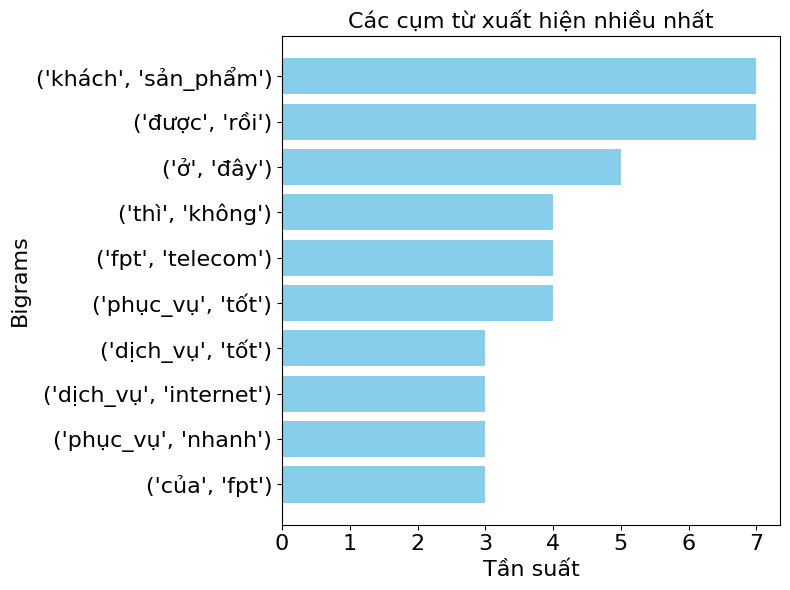

In [134]:
import itertools
import collections
import matplotlib.pyplot as plt 

bigrams = list(itertools.chain(*terms_bigram))
bigram_counts = collections.Counter(bigrams)
top_25_bigrams = bigram_counts.most_common(25)
bigram_labels, counts = zip(*top_25_bigrams[:10])

plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.barh(range(len(bigram_labels)), counts, color='skyblue')
plt.yticks(range(len(bigram_labels)), bigram_labels,fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('Tần suất',fontsize=16)
plt.ylabel('Bigrams',fontsize=16)
plt.title('Các cụm từ xuất hiện nhiều nhất',fontsize=16)
plt.tight_layout()
plt.gca().invert_yaxis()  
plt.show()

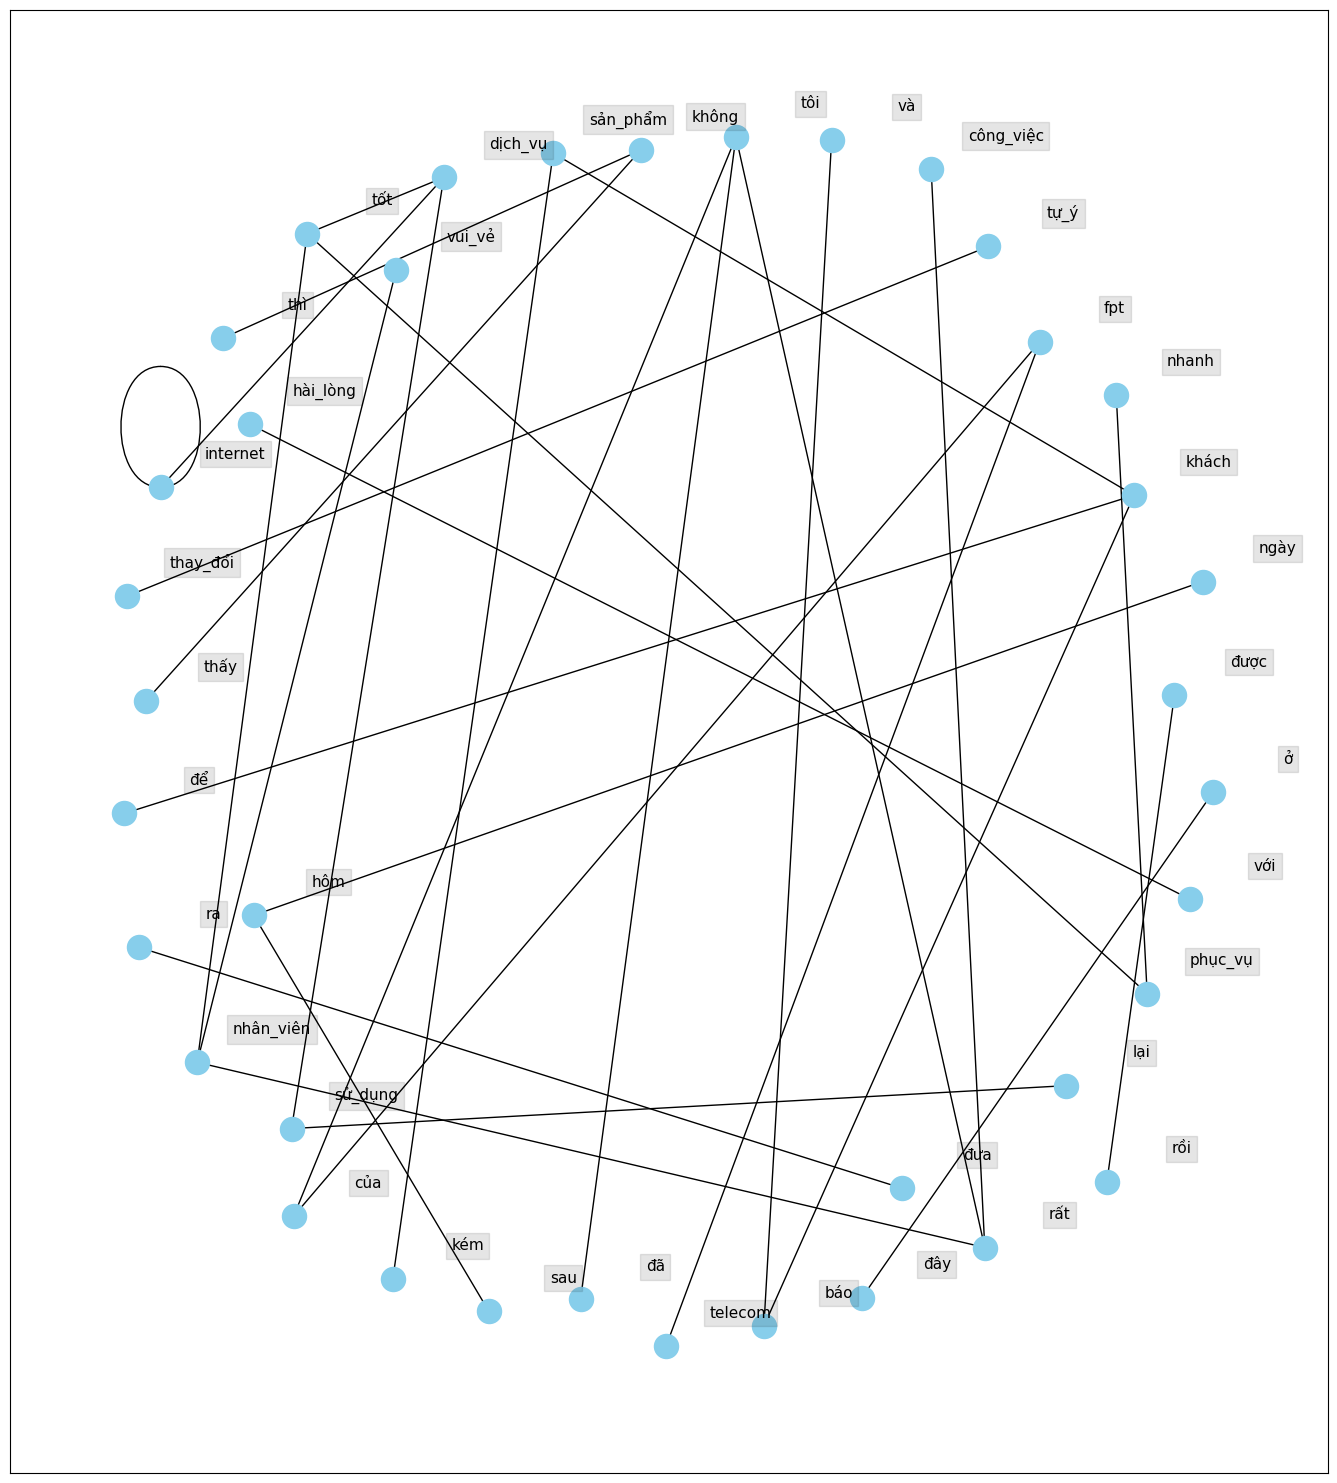

In [34]:
bigram_df = pd.DataFrame(bigram_counts.most_common(30),columns=['unigram', 'count'])

d = bigram_df.set_index('unigram').T.to_dict('records')
G = nx.Graph()

for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

fig, ax = plt.subplots(figsize=(17, 19))
pos = nx.spring_layout(G, k=10)

nx.draw_networkx(G, pos,
                 edge_color='black',
                 node_color='skyblue',
                 with_labels = False,
                 ax=ax)

for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='black', alpha=0.10),
            horizontalalignment='center', fontsize=11)
plt.savefig('wordnet.pdf')
plt.show()

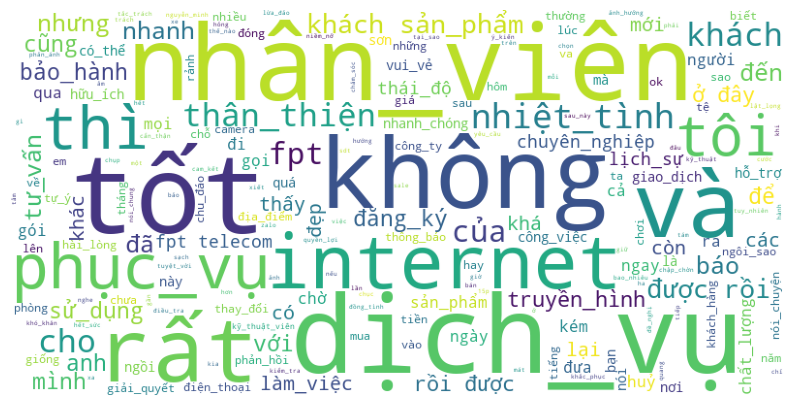

In [36]:
from wordcloud import WordCloud
text = " ".join(data['Processed Review Text'])
wordcloud = WordCloud(width=800,
                      height=400,
                      background_color='white',
                      colormap='viridis',
                      stopwords=None).generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('wordcloud.pdf')
plt.show()

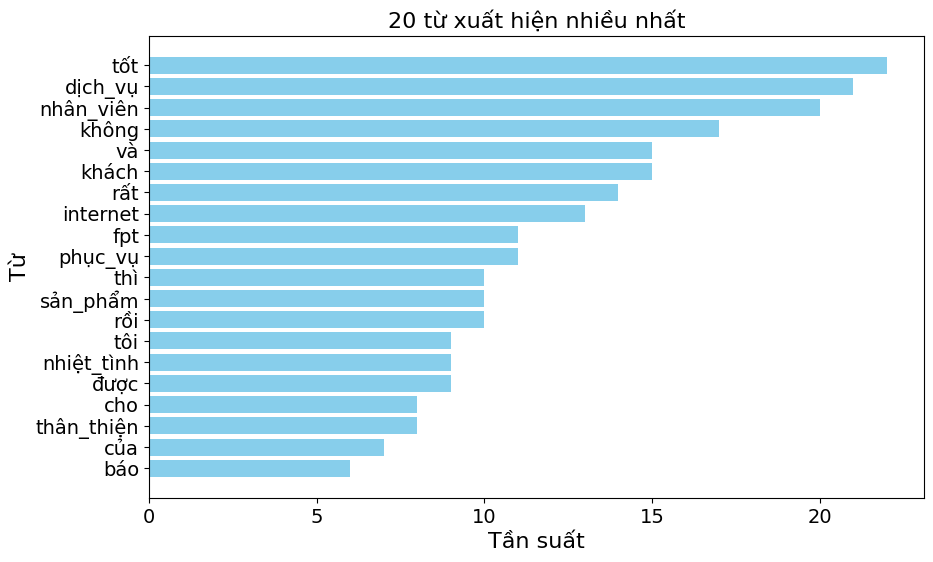

In [57]:
from collections import Counter  # Import từ collections
words = text.split()
word_counts = Counter(words)
top_20_words = word_counts.most_common(20)
top_words, word_freqs = zip(*top_20_words)

# Plot the top 20 words
plt.figure(figsize=(10, 6))
plt.barh(top_words, word_freqs, color='skyblue')
plt.xlabel('Tần suất',fontsize=16)
plt.ylabel('Từ',fontsize=16)
plt.title('20 từ xuất hiện nhiều nhất',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().invert_yaxis() 
plt.savefig('word-freq.pdf')
plt.show()

In [ ]:
data = pd.read_csv('/kaggle/input/google-fpt-telecom-reviews-data/reviews.csv')
data['Review Time'].value_counts()

In [40]:
from datetime import datetime, timedelta

# Lấy ngày hiện tại
nowdate = datetime.now()

# Từ điển ánh xạ số từ chữ sang số nguyên
number_map = {
    'một': 1,
    'hai': 2,
    'ba': 3,
    'bốn': 4,
    'năm': 5,
    'sáu': 6,
    'bảy': 7,
    'tám': 8,
    'chín': 9,
    'mười': 10
}

# Hàm chuyển đổi 'Review Time' thành ngày
def convert_to_date(review_time):
    parts = review_time.split()
    
    if len(parts) == 3:  # Xử lý trường hợp như 'một tuần trước'
        num_str = parts[0]
        unit = parts[1]
        
        # Xử lý trường hợp số chữ
        if num_str in number_map:
            number = number_map[num_str]
        else:
            try:
                number = int(num_str)  
            except ValueError:
                return pd.NaT  # Trả về NaT nếu không thể chuyển đổi
        
        if 'năm' in unit:
            return nowdate - timedelta(days=number * 365)  
        elif 'tháng' in unit:
            return nowdate - timedelta(days=number * 30)  
        elif 'tuần' in unit:
            return nowdate - timedelta(weeks=number) 
    return pd.NaT  

data['Review Date'] = data['Review Time'].apply(convert_to_date)
data[['Review Time', 'Review Date']]

/tmp/ipykernel_29/3126933580.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Review Date'] = data['Review Time'].apply(convert_to_date)


,Review Time,Review Date
0,một tuần trước,2024-10-19 03:30:47.186417
1,một tháng trước,2024-09-26 03:30:47.186417
2,6 tháng trước,2024-04-29 03:30:47.186417
3,8 tháng trước,2024-02-29 03:30:47.186417
4,2 năm trước,2022-10-27 03:30:47.186417
...,...,...
103,4 năm trước,2020-10-27 03:30:47.186417
137,5 năm trước,2019-10-28 03:30:47.186417
153,6 năm trước,2018-10-28 03:30:47.186417
158,6 năm trước,2018-10-28 03:30:47.186417


In [43]:
# Xử lý cột Rating để trả về từ "5 sao" thành "5"
data.loc[:, 'Rating'] = data['Rating'].apply(lambda x: int(x.replace(' sao', '')))

In [80]:
datas = pd.read_csv('/kaggle/input/google-fpt-telecom-reviews-data/reviews.csv')
datas.loc[:, 'Rating'] = datas['Rating'].apply(lambda x: int(x.replace(' sao', '')))

In [110]:
import pandas as pd
import plotly.express as px

# Giả định bạn đã có DataFrame 'datas' với cột 'Rating'
# Đảm bảo cột 'Rating' là kiểu dữ liệu số
datas['Rating'] = datas['Rating'].astype(int)

# Đếm số lượng đánh giá theo từng loại sao
rating_counts = datas['Rating'].value_counts().reset_index()
rating_counts.columns = ['Star Rating', 'Count']

# Ánh xạ giá trị Count vào thang màu, với giá trị thấp nhất là 0.0
rating_counts['Color Scale'] = rating_counts['Count'].apply(
    lambda x: 1.0 if x >= 60 else 
              (0.95 if x >= 40 else 
               (0.85 if x >= 30 else 
                (0.75 if x >= 15 else 
                 (0.65 if x >=14 else
                  (0.50 if x >= 5 else 0.0)))))  # Duy trì giá trị tối thiểu là 0.0
)

# Vẽ biểu đồ cột
fig = px.bar(rating_counts, x='Star Rating', y='Count',
              title='Thống kê số lượng Đánh giá theo sao',
              labels={'Star Rating': 'Sao', 'Count': 'Số lượng đánh giá'},
              color='Color Scale',  # Màu sắc theo thang màu đã xác định
              color_continuous_scale=px.colors.sequential.Blues,  # Sử dụng thang màu xanh dương
              range_color=[0.0, 1.0]  # Đặt khoảng màu sắc từ 0.0 đến 1.0
)

# Cài đặt trục
fig.update_layout(
    xaxis=dict(title='Sao'),
    yaxis=dict(title='Số lượng'),
    template='plotly_white'
)

fig.show()


## 🧮 Visualize theo trên 4 sao và dưới 4 sao

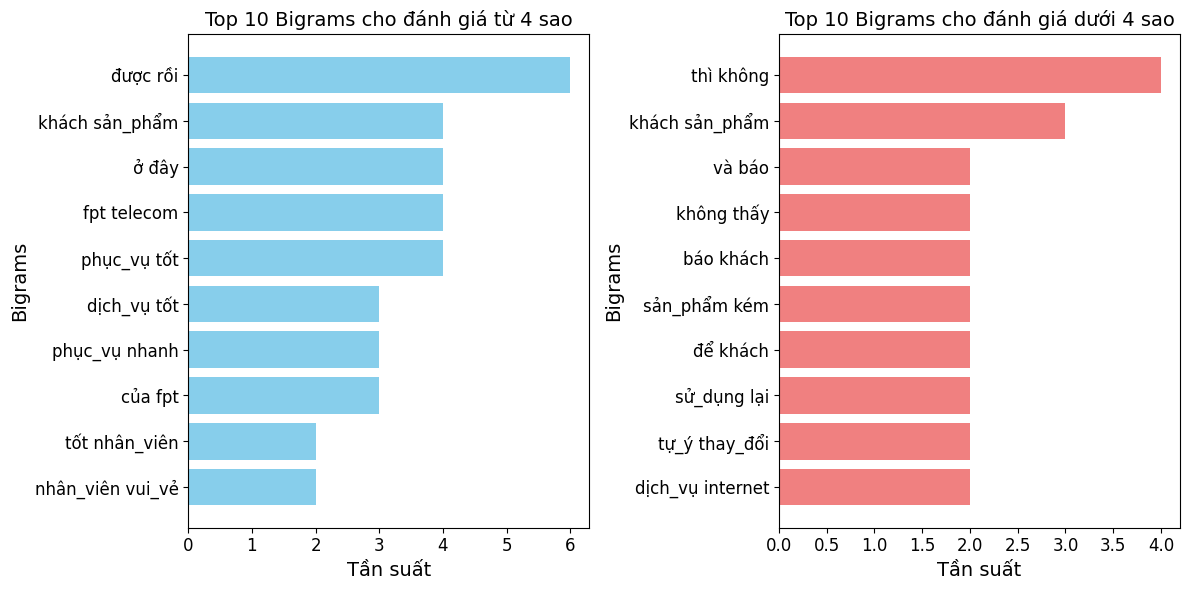

In [132]:
# Lọc danh sách bigram cho đánh giá >= 4 sao
high_rating_bigrams = list(itertools.chain(*data[data['Rating'] >= 4]['bigram'].tolist()))
bigram_counts_high = collections.Counter(high_rating_bigrams)
top_10_bigrams_high = bigram_counts_high.most_common(10)
bigram_labels_high, counts_high = zip(*top_10_bigrams_high)

# Lọc danh sách bigram cho đánh giá < 4 sao
low_rating_bigrams = list(itertools.chain(*data[data['Rating'] < 4]['bigram'].tolist()))
bigram_counts_low = collections.Counter(low_rating_bigrams)
top_10_bigrams_low = bigram_counts_low.most_common(10)
bigram_labels_low, counts_low = zip(*top_10_bigrams_low)

# Vẽ biểu đồ cho bigram của các đánh giá >= 4 sao
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 hàng, 2 cột, thứ tự 1
plt.barh(range(len(bigram_labels_high)), counts_high, color='skyblue')
plt.yticks(range(len(bigram_labels_high)), bigram_labels_high, fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Tần suất', fontsize=14)
plt.ylabel('Bigrams', fontsize=14)
plt.title('Top 10 Bigrams cho đánh giá từ 4 sao', fontsize=14)
plt.gca().invert_yaxis() 

# Vẽ biểu đồ cho bigram của các đánh giá < 4 sao
plt.subplot(1, 2, 2)  # 1 hàng, 2 cột, thứ tự 2
plt.barh(range(len(bigram_labels_low)), counts_low, color='lightcoral')
plt.yticks(range(len(bigram_labels_low)), bigram_labels_low, fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Tần suất', fontsize=14)
plt.ylabel('Bigrams', fontsize=14)
plt.title('Top 10 Bigrams cho đánh giá dưới 4 sao', fontsize=14)
plt.gca().invert_yaxis()  

# Cài đặt bố cục
plt.tight_layout()
plt.savefig('top_bigrams.pdf')  # Lưu biểu đồ vào file PDF
plt.show()


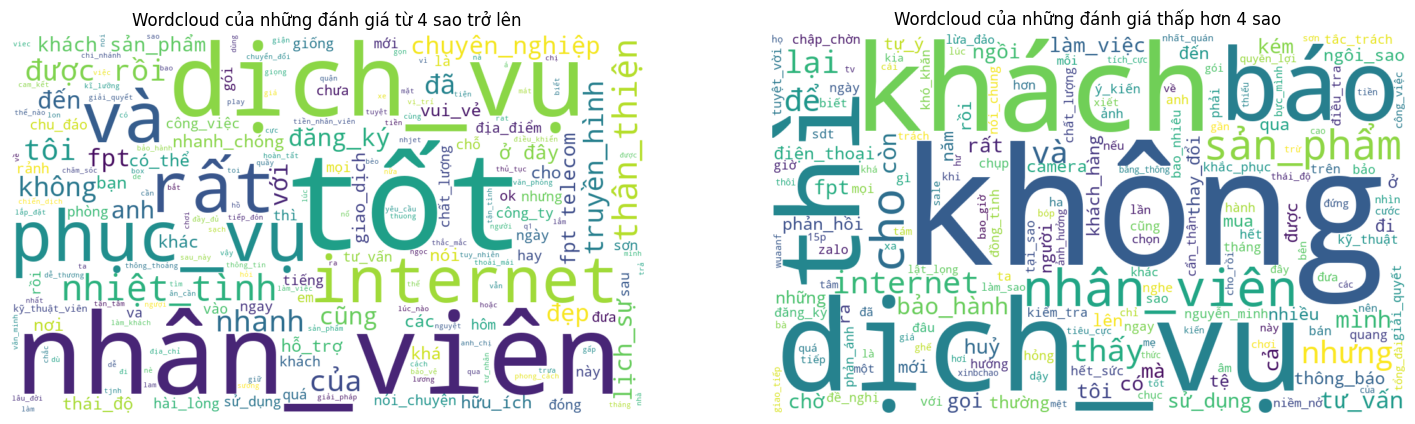

In [119]:
from wordcloud import WordCloud

# Lọc dữ liệu cho các đánh giá >= 4 sao
high_rating_reviews = data[data['Rating'] >= 4]['Processed Review Text']
low_rating_reviews = data[data['Rating'] < 4]['Processed Review Text']

# Tạo WordCloud cho các đánh giá >= 4 sao
high_rating_text = " ".join(high_rating_reviews)
wordcloud_high = WordCloud(width=1000,
                            height=600,
                            background_color='white',
                            colormap='viridis',
                            stopwords=None).generate(high_rating_text)

# Tạo WordCloud cho các đánh giá < 4 sao
low_rating_text = " ".join(low_rating_reviews)
wordcloud_low = WordCloud(width=1000,
                           height=600,
                           background_color='white',
                           colormap='viridis',
                           stopwords=None).generate(low_rating_text)

# Vẽ biểu đồ WordCloud cho các đánh giá >= 4 sao
plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)  
plt.imshow(wordcloud_high, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud của những đánh giá từ 4 sao trở lên')

# Vẽ biểu đồ WordCloud cho các đánh giá < 4 sao
plt.subplot(1, 2, 2)  
plt.imshow(wordcloud_low, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud của những đánh giá thấp hơn 4 sao')

# Lưu biểu đồ
plt.show()

## 🧮 Theo thời gian

In [133]:
import plotly.express as px
import plotly.graph_objects as go

# Chuyển đổi 'Review Date' thành định dạng datetime
data.loc[:, 'Review Date'] = pd.to_datetime(data['Review Date'])

# Tạo cột 'Year' từ cột 'Review Date'
data.loc[:, 'Year'] = data['Review Date'].dt.year

# Tính trung bình rating và số lượng đánh giá theo năm
avg_rating_per_year = data.groupby('Year')['Rating'].mean().reset_index()
count_reviews_per_year = data.groupby('Year')['Rating'].count().reset_index(name='Count')

# Gộp cả hai DataFrame lại
avg_count_per_year = pd.merge(avg_rating_per_year, count_reviews_per_year, on='Year')

# Tạo biểu đồ
fig = go.Figure()

# Thêm đường cho trung bình rating
fig.add_trace(go.Scatter(
    x=avg_count_per_year['Year'],
    y=avg_count_per_year['Rating'],
    mode='lines+markers',
    name='Trung bình Rating',
    line=dict(color='blue')
))

# Thêm đường cho số lượng đánh giá
fig.add_trace(go.Scatter(
    x=avg_count_per_year['Year'],
    y=avg_count_per_year['Count'],
    mode='lines+markers',
    name='Số lượng Đánh giá',
    line=dict(color='red'),
    yaxis='y2'  # Đặt vào trục thứ hai
))

# Cài đặt trục thứ hai
fig.update_layout(
    title='Trung bình Rating và Số lượng Đánh giá theo năm',
    xaxis=dict(title='Năm'),
    yaxis=dict(title='Trung bình Rating', side='left', titlefont=dict(color='blue')),
    yaxis2=dict(
        title='Số lượng Đánh giá',
        overlaying='y',
        side='right',
        titlefont=dict(color='red')
    ),
    template='plotly_white'
)
fig.update_layout(
    template='plotly_white',
        legend=dict(
        x=0.81,  # Di chuyển legend sang bên phải
        y=0.98,  # Di chuyển legend lên phía trên
        traceorder='normal',
        font=dict(
            size=12
        ),
    ),
)
fig.show()


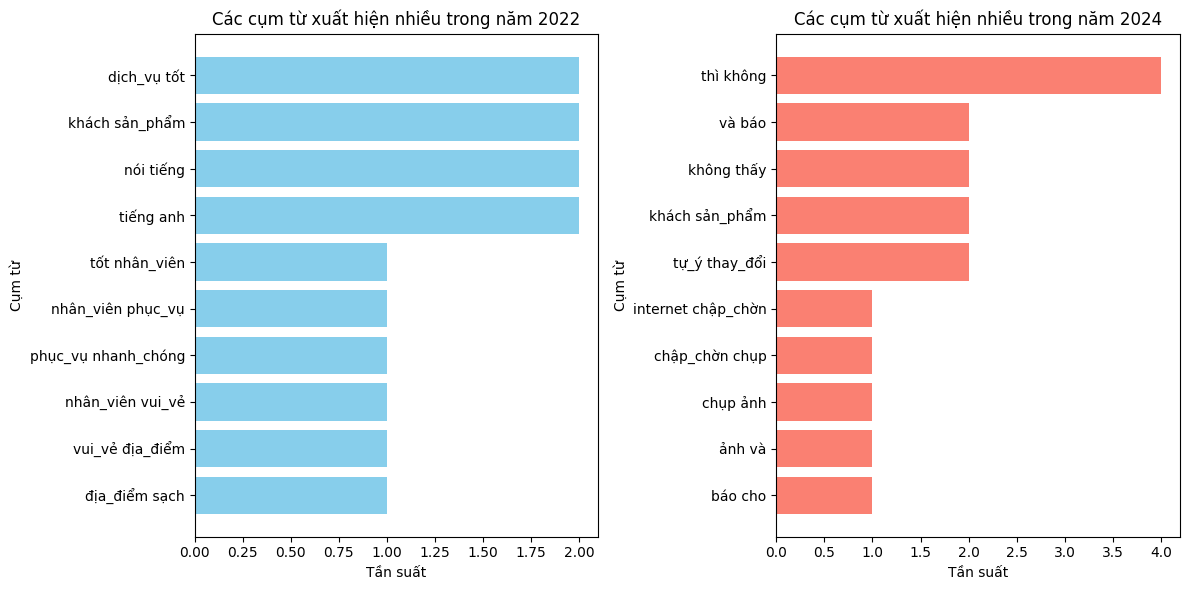

In [51]:
import itertools
from collections import Counter
import matplotlib.pyplot as plt

# Giả sử dữ liệu của bạn là trong một DataFrame tên là `data`

# Tách các bigram theo năm
bigram_2022 = data[data['Year'] == 2022]['bigram']
bigram_2024 = data[data['Year'] == 2024]['bigram']

# Kết hợp tất cả các bigram thành một danh sách
bigrams_2022 = list(itertools.chain(*bigram_2022))
bigrams_2024 = list(itertools.chain(*bigram_2024))

# Đếm số lần xuất hiện của từng bigram
bigram_counts_2022 = Counter(bigrams_2022)
bigram_counts_2024 = Counter(bigrams_2024)

# Lấy ra top 10 bigram cho từng năm
top_10_bigrams_2022 = bigram_counts_2022.most_common(10)
top_10_bigrams_2024 = bigram_counts_2024.most_common(10)

# Tách bigram và count cho biểu đồ
bigrams_2022, counts_2022 = zip(*top_10_bigrams_2022)
bigrams_2024, counts_2024 = zip(*top_10_bigrams_2024)

# Tạo biểu đồ
plt.figure(figsize=(12, 6))

# Vẽ biểu đồ cho năm 2022
plt.subplot(1, 2, 1)
plt.barh(bigrams_2022, counts_2022, color='skyblue')
plt.xlabel('Tần suất')
plt.ylabel('Cụm từ')
plt.title('Các cụm từ xuất hiện nhiều trong năm 2022')
plt.gca().invert_yaxis()  # Đảo ngược trục y để bigram có tần suất cao nhất lên đầu

# Vẽ biểu đồ cho năm 2024
plt.subplot(1, 2, 2)
plt.barh(bigrams_2024, counts_2024, color='salmon')
plt.xlabel('Tần suất')
plt.ylabel('Cụm từ')
plt.title('Các cụm từ xuất hiện nhiều trong năm 2024')
plt.gca().invert_yaxis()  # Đảo ngược trục y để bigram có tần suất cao nhất lên đầu

plt.tight_layout()
plt.show()
